Quantified backlog state = Sum(Rule \* Weight \* 10)

This will give the team clear information about backlog state score in a number from 1-10 (1 - worst, 10 - best )
Weights need to sum up to 100%



In [154]:
from jira import JIRA
import matplotlib.pyplot as plt
import pandas as pd
import re
from numpy import nan
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [155]:


#to show all rules descriptions
pd.set_option('max_colwidth',200)

rules = pd.DataFrame()
rules['rule'] = ''
rules['weight'] = 0
rules['value'] = 0

rules['rule'] = ['In next 2 sprints there are items in Backlog state that SP sum is greater than estimated velocity, there are no items assigned to sprint that are not in Backlog state - Y/N',
                '#rule 1 Planned next 3 versions (all items estimated and in Backlog or started state (not in presprint) - Y/N',
                '% of Must, Urgent, Should items that are estimated regardless of status',
                '% of key milestone items estimated and in Backlog status']
rules['weight'] = [0.4, 0.25, 0.25, 0.1]

rules

,rule,weight,value
0,"In next 2 sprints there are items in Backlog state that SP sum is greater than estimated velocity, there are no items assigned to sprint that are not in Backlog state - Y/N",0.40,NaN
1,#rule 1 Planned next 3 versions (all items estimated and in Backlog or started state (not in presprint) - Y/N,0.25,NaN
2,"% of Must, Urgent, Should items that are estimated regardless of status",0.25,NaN
3,% of key milestone items estimated and in Backlog status,0.10,NaN


Rules sum should be 1

In [156]:
sum(rules.weight)

1.0

<div class="alert alert-block alert-success">
Set up nextSprint, currentVersion, nextVersion values.

They can be loaded automatically from Jira too.
</div>

In [157]:
nextSprints = ['IC - #4 20180219 - 1.13', 'IC - #5 20180305 - 1.14']

#velocity used to check if sprints are planned correctly
estimatedVelocity = 13

nextVersions = ['1.12', '1.13', '1.14', '1.15', '1.16']
milestones = ['Frimley MVP']

In [158]:

jira_url = 'https://kainos-evolve.atlassian.net'
jira = JIRA(jira_url)

In [159]:
#rule 0
#In next 2 sprints there are items in Backlog state that SP sum is greater than estimated velocity, 
#there are no items assigned to sprint that are not in Backlog state - Y/N
#bugs don't have to be estimated

jql = 'sprint in ("{}") and type != Bug and status = Backlog and type not in subTaskIssueTypes()'.format('", "'.join(nextSprints))
jql

issuesRaw = jira.search_issues(jql)

issues = pd.DataFrame()
issues['key'] = ''
issues['sprint'] = ''
issues['SP'] = ''
issues['type'] = ''
issues['status'] = ''
issues['summary'] = ''

for issue in issuesRaw:
    for rawSprint in issue.fields.customfield_10007:
        #unfortunately sprint information is encoded and regex is needed
        matches = re.search('name=(.*?),', rawSprint)
        issues = issues.append(
            {
             'key': issue.key,
             'type': issue.fields.issuetype.name,
             'status': issue.fields.status.name,
             'SP' : issue.fields.customfield_10005,
             'summary': issue.fields.summary,
             'sprint' : matches.group(1)
            }, ignore_index=True)

issues.fillna(value=nan, inplace=True)
issues
#issues.fillna(0, inplace=True)


sprints = issues.groupby(['sprint']).agg({'SP':'sum'})
sprints = sprints.loc[(sprints['SP'] >= estimatedVelocity)]
sprints
#non zero SP sprints number should be equal to number of next sprints
rule_value = (len(sprints) == len(nextSprints))
rules.at[0, 'value'] = int(rule_value)

'sprint in ("IC - #4 20180219 - 1.13", "IC - #5 20180305 - 1.14") and type != Bug and status = Backlog and type not in subTaskIssueTypes()'

,key,sprint,SP,type,status,summary


,key,sprint,SP,type,status,summary


,SP
sprint,


In [160]:
#rule 1 Planned next 3 versions (all items estimated and in Backlog or started state (not in presprint) - Y/N
jql = 'fixVersion in ("{}") and type not in subTaskIssueTypes()'.format('", "'.join(nextVersions))
jql

issuesRaw = jira.search_issues(jql)

issues = pd.DataFrame()
issues['key'] = ''
issues['version'] = ''
issues['SP'] = ''
issues['type'] = ''
issues['status'] = ''
issues['summary'] = ''

#add issues to dataframe
for issue in issuesRaw:
    #issue may have many versions - in this approach, one version per issue is recommended
    for fixVersion in issue.fields.fixVersions:
        if(fixVersion.name in nextVersions):
            issues = issues.append(
                {'version': fixVersion.name, 
                 'key': issue.key,
                 'type': issue.fields.issuetype.name,
                 'status': issue.fields.status.name,
                 'SP': issue.fields.customfield_10005,
                 'summary': issue.fields.summary,
                 'team' : str(issue.fields.customfield_14200),
                }, ignore_index=True)
            
issues = issues.loc[~(issues['status'].isin(['Completed', 'Rejected']))]

#indicate not estimated issues, bugs don't have to be estimated
issues['isEstimated'] = False
issues.loc[(issues['type'].isin(['Bug', 'Epic'])), ['isEstimated']] = True
issues.loc[(issues['type'] != 'Bug') & ~(issues['SP'].isnull()), ['isEstimated']] = True

#indicate items in presprint
issues['inPresprint'] = False
issues.loc[(issues['status'].isin(['Awaiting Prioritisation', 'PO Refinement', 'UX Refinement', 'QA Refinement', 'Tech Refinement', 
                                  'Tech Refinement', 'Estimation'])), ['inPresprint']] = True
issues.sort_values("version", inplace=True)



issues = issues.loc[(issues['inPresprint'] == True) | (issues['isEstimated'] == False)]
issues

rule_value = len(issues) == 0
rules.at[1, 'value'] = int(rule_value)


'fixVersion in ("1.12", "1.13", "1.14", "1.15", "1.16") and type not in subTaskIssueTypes()'

,key,version,SP,type,status,summary,team,isEstimated,inPresprint
0,VXT-4100,1.13,NaN,Story,Estimation,User Encounter Tasks (Patient Manager) MVP,Gdansk Team 1,False,True
35,VXT-3736,1.13,NaN,Bug,QA Refinement,EDM allows privilege escalation,Gdansk Team 1,True,True
24,VXT-3938,1.13,NaN,Story,Tech Refinement,Ability to use data model objects read from FHIR throughout activiti processes,Gdansk Team 1,False,True
6,VXT-4028,1.13,NaN,Story,Tech Refinement,Disable GroovyScript execution in Activiti,Gdansk Team 1,False,True
5,VXT-4058,1.13,NaN,Bug,QA Refinement,FHIR Table control should be able to optionally store values read into table.,Gdansk Team 1,True,True
40,VXT-3678,1.14,NaN,Story,Estimation,Custom Controls - Unable to identify version number,Gdansk Team 1,False,True
4,VXT-4061,1.15,NaN,Story,Tech Refinement,Build and provide ability to generate a report for a single process,Gdansk Team 1,False,True
3,VXT-4062,1.15,NaN,Story,Tech Refinement,Provide ability to generate a report for a multiple encounters/processes in a given date range,Gdansk Team 1,False,True
19,VXT-3986,1.16,NaN,Story,Backlog,Keycloak HA,Gdansk Team 1,False,False


In [161]:
#rule 2
# % of Must, Urgent, Should items that are estimated regardless of status
# bugs don't have to be estimated
jql = 'project = VXT and priority in (Must,Urgent,Should) and type != Bug and type not in subTaskIssueTypes()'
jql

issuesRaw = jira.search_issues(jql)

issues = pd.DataFrame()
issues['key'] = ''
issues['version'] = ''
issues['SP'] = ''
issues['type'] = ''
issues['status'] = ''
issues['summary'] = ''
issues['priority'] = ''

#add issues to dataframe
for issue in issuesRaw:
    #issue may have many versions - in this approach, one version per issue is recommended
    for fixVersion in issue.fields.fixVersions:
        if(fixVersion.name in nextVersions):
            issues = issues.append(
                {'version': fixVersion.name, 
                 'key': issue.key,
                 'type': issue.fields.issuetype.name,
                 'status': issue.fields.status.name,
                 'SP': issue.fields.customfield_10005,
                 'summary': issue.fields.summary,
                 'priority' : str(issue.fields.priority.name),
                }, ignore_index=True)
issues

rule_value = round(len(issues.loc[~(issues['SP'].isnull())]) / len(issues), 2)
rules.at[2, 'value'] = rule_value

'project = VXT and priority in (Must,Urgent,Should) and type != Bug and type not in subTaskIssueTypes()'

,key,version,SP,type,status,summary,priority
0,VXT-4100,1.13,NaN,Story,Estimation,User Encounter Tasks (Patient Manager) MVP,URGENT
1,VXT-4098,1.12,1.0,Story,Backlog,Set associated limits across production account / region,SHOULD
2,VXT-4092,1.12,2.0,Story,In Development,Release 1.12,SHOULD
3,VXT-4062,1.15,NaN,Story,Tech Refinement,Provide ability to generate a report for a multiple encounters/processes in a given date range,MUST
4,VXT-4061,1.15,NaN,Story,Tech Refinement,Build and provide ability to generate a report for a single process,MUST
5,VXT-4028,1.13,NaN,Story,Tech Refinement,Disable GroovyScript execution in Activiti,MUST


In [162]:
# % of key milestone items estimated and in Backlog status
jql = 'project = VXT and type != Epic and status not in (Rejected, Completed) and type not in subTaskIssueTypes() and fixVersion in ("' + '", "'.join(milestones) + '")'
jql

issuesRaw = jira.search_issues(jql)

issues = pd.DataFrame()
issues['key'] = ''
issues['version'] = ''
issues['SP'] = ''
issues['type'] = ''
issues['status'] = ''
issues['summary'] = ''

#add issues to dataframe
for issue in issuesRaw:
    #issue may have many versions - in this approach, one version per issue is recommended
    for fixVersion in issue.fields.fixVersions:
        if(fixVersion.name in milestones):
            issues = issues.append(
                {'version': fixVersion.name, 
                 'key': issue.key,
                 'type': issue.fields.issuetype.name,
                 'status': issue.fields.status.name,
                 'SP': issue.fields.customfield_10005,
                 'summary': issue.fields.summary,
                }, ignore_index=True)
            
issues['isEstimated'] = False
issues.loc[(issues['type'] == 'Bug'), ['isEstimated']] = True
issues.loc[(issues['type'] != 'Bug') & ~(issues['SP'].isnull()), ['isEstimated']] = True
issues

rule_value = round(len(issues.loc[(issues['isEstimated'] == True)]) / len(issues), 2)
rule_value
rules.at[3, 'value'] = rule_value

'project = VXT and type != Epic and status not in (Rejected, Completed) and type not in subTaskIssueTypes() and fixVersion in ("Frimley MVP")'

,key,version,SP,type,status,summary,isEstimated
0,VXT-4100,Frimley MVP,NaN,Story,Estimation,User Encounter Tasks (Patient Manager) MVP,False
1,VXT-4098,Frimley MVP,1.0,Story,Backlog,Set associated limits across production account / region,True
2,VXT-4087,Frimley MVP,NaN,Bug,Backlog,Tab status for required fields is not refreshing on time for text fields,True
3,VXT-4085,Frimley MVP,NaN,Bug,Backlog,JIT user recreation fails due to autogenerated user id's and no-deletion policy in BPM,True
4,VXT-4058,Frimley MVP,NaN,Bug,QA Refinement,FHIR Table control should be able to optionally store values read into table.,True
5,VXT-4028,Frimley MVP,NaN,Story,Tech Refinement,Disable GroovyScript execution in Activiti,False
6,VXT-4026,Frimley MVP,NaN,Bug,Backlog,Visibility condition trigger for multi-line text box is not triggering and value does not save correctly,True
7,VXT-4025,Frimley MVP,2.0,Story,In Code review,Rebrand IC configured default tenant logos/images to Evolve Logo,True
8,VXT-4021,Frimley MVP,NaN,Bug,Awaiting Review,"Form renderer tabs will display ""Required *"" when required fields are hidden with visibility conditions",True
9,VXT-4017,Frimley MVP,1.0,Story,Estimation,Configure Users and Basic Setup (Status.io),True


0.76

In [163]:
rules['score'] = rules.weight * rules.value * 10
rules

,rule,weight,value,score
0,"In next 2 sprints there are items in Backlog state that SP sum is greater than estimated velocity, there are no items assigned to sprint that are not in Backlog state - Y/N",0.40,0.00,0.000
1,#rule 1 Planned next 3 versions (all items estimated and in Backlog or started state (not in presprint) - Y/N,0.25,0.00,0.000
2,"% of Must, Urgent, Should items that are estimated regardless of status",0.25,0.33,0.825
3,% of key milestone items estimated and in Backlog status,0.10,0.76,0.760


Backlog score 1.59 / 10


(0, 10)

,date,score
0,2018-02-19 11:08:37,1.59
1,2018-02-19 11:08:45,1.59
2,2018-02-19 11:08:50,1.59
3,2018-02-19 11:10:13,1.59
4,2018-02-19 11:10:53,1.59
5,2018-02-19 11:11:14,1.59
6,2018-02-19 11:14:42,1.59
7,2018-02-19 11:17:14,1.59


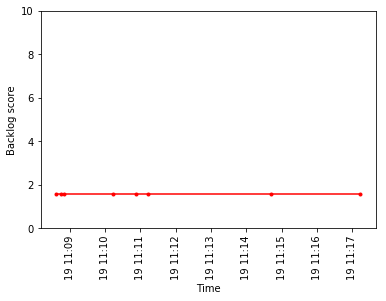

In [164]:
score = round(sum(rules['score']), 2)


%store -r

if not 'scores' in globals():
    scores = pd.DataFrame()
    scores['date'] = ''
    scores['score'] = 0

scores = scores.append(
            {
             'date': pd.to_datetime('now'),
             'score': score,
            }, ignore_index=True)


print("Backlog score {} / 10".format(score))

_ = plt.plot(scores['date'], scores['score'], "-r.")

_ = plt.xticks(rotation='vertical')
_ = plt.ylabel('Backlog score')
_ = plt.xlabel('Time')
axes = plt.gca()
axes.set_ylim([0,10])

scores